In [1]:
!pip install tf-nightly

     |████████████████████████████████| 323.0 MB 15 kB/s 
     |████████████████████████████████| 459 kB 47.1 MB/s 
     |████████████████████████████████| 6.8 MB 47.3 MB/s 


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import shutil

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!ls "../input/plant-pathology-2020-fgvc7"

images	sample_submission.csv  test.csv  train.csv


# Prep directory for building the dataset 

In [4]:
!ls

__notebook__.ipynb


In [5]:
!mkdir classed

In [6]:
BASE_DIR = "../input/plant-pathology-2020-fgvc7"
IMG_DIR =  "images"
CL_IMG_DIR = "classed"

In [7]:
train_labels_df = pd.read_csv(os.path.join(BASE_DIR, "train.csv"))


In [8]:
train_labels_dict = train_labels_df.to_dict()


In [9]:
# restructure image folder for classes 
healthy = []
multiple = []
rust = []
scab = []

# for file_ in train_filenames:
#   print(file_)
for i in train_labels_dict["image_id"]:
  if train_labels_dict["healthy"][i] == 1:
    # print(i, " is healthy")
    healthy.append(os.path.join(BASE_DIR, IMG_DIR, "Train_" + str(i) + ".jpg"))
  
  if train_labels_dict["multiple_diseases"][i] == 1:
    # print(i, " is multiple")
    multiple.append(os.path.join(BASE_DIR, IMG_DIR, "Train_" + str(i) + ".jpg"))

  if train_labels_dict["rust"][i] == 1:
    # print(i, " is scab")
    rust.append(os.path.join(BASE_DIR, IMG_DIR, "Train_" + str(i) + ".jpg"))

  if train_labels_dict["scab"][i] == 1:
    # print(i, " is rust")
    scab.append(os.path.join(BASE_DIR, IMG_DIR, "Train_" + str(i) + ".jpg"))
    
healthy[:5], multiple[:5], rust[:5], scab[:5]


(['../input/plant-pathology-2020-fgvc7/images/Train_2.jpg',
  '../input/plant-pathology-2020-fgvc7/images/Train_4.jpg',
  '../input/plant-pathology-2020-fgvc7/images/Train_5.jpg',
  '../input/plant-pathology-2020-fgvc7/images/Train_9.jpg',
  '../input/plant-pathology-2020-fgvc7/images/Train_13.jpg'],
 ['../input/plant-pathology-2020-fgvc7/images/Train_1.jpg',
  '../input/plant-pathology-2020-fgvc7/images/Train_6.jpg',
  '../input/plant-pathology-2020-fgvc7/images/Train_25.jpg',
  '../input/plant-pathology-2020-fgvc7/images/Train_36.jpg',
  '../input/plant-pathology-2020-fgvc7/images/Train_62.jpg'],
 ['../input/plant-pathology-2020-fgvc7/images/Train_3.jpg',
  '../input/plant-pathology-2020-fgvc7/images/Train_10.jpg',
  '../input/plant-pathology-2020-fgvc7/images/Train_14.jpg',
  '../input/plant-pathology-2020-fgvc7/images/Train_15.jpg',
  '../input/plant-pathology-2020-fgvc7/images/Train_21.jpg'],
 ['../input/plant-pathology-2020-fgvc7/images/Train_0.jpg',
  '../input/plant-pathology-2

In [10]:
classes_ = [class_ for class_ in train_labels_df.columns[1:5]]

In [11]:
for class_ in classes_:
    !mkdir classed/{class_}

In [12]:
for dir in healthy:
  shutil.copy2(dir, "classed/healthy")

for dir in multiple:
  shutil.copy2(dir, "classed/multiple_diseases")


for dir in rust:
  shutil.copy2(dir, "classed/rust")

for dir in scab:
  shutil.copy2(dir, "classed/scab")

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [14]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

Num GPUs Available:  1


['/device:GPU:0']

In [15]:
image_size = (256, 256)
batch_size = 32
seed = 128
val_split = 0.2


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "classed", 
    labels='inferred', 
    label_mode='categorical', 
    class_names=classes_,
    color_mode='rgb',
    validation_split=val_split,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "classed", 
    labels='inferred', 
    label_mode='categorical', 
    class_names=classes_,
    color_mode='rgb',
    validation_split=val_split,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1821 files belonging to 4 classes.
Using 1457 files for training.
Found 1821 files belonging to 4 classes.
Using 364 files for validation.


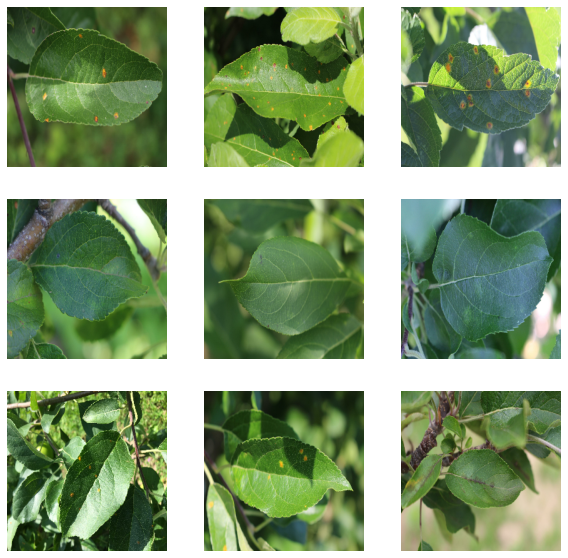

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(labels[i])
        plt.axis("off")

In [17]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

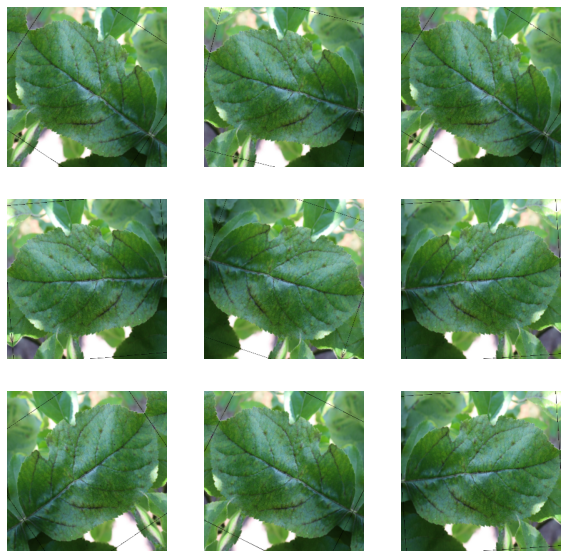

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[5].numpy().astype("uint8"))
        plt.axis("off")

In [19]:
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE).cache()
val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE).cache()

In [20]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 4:
        activation = "sigmoid"
        units = 4
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

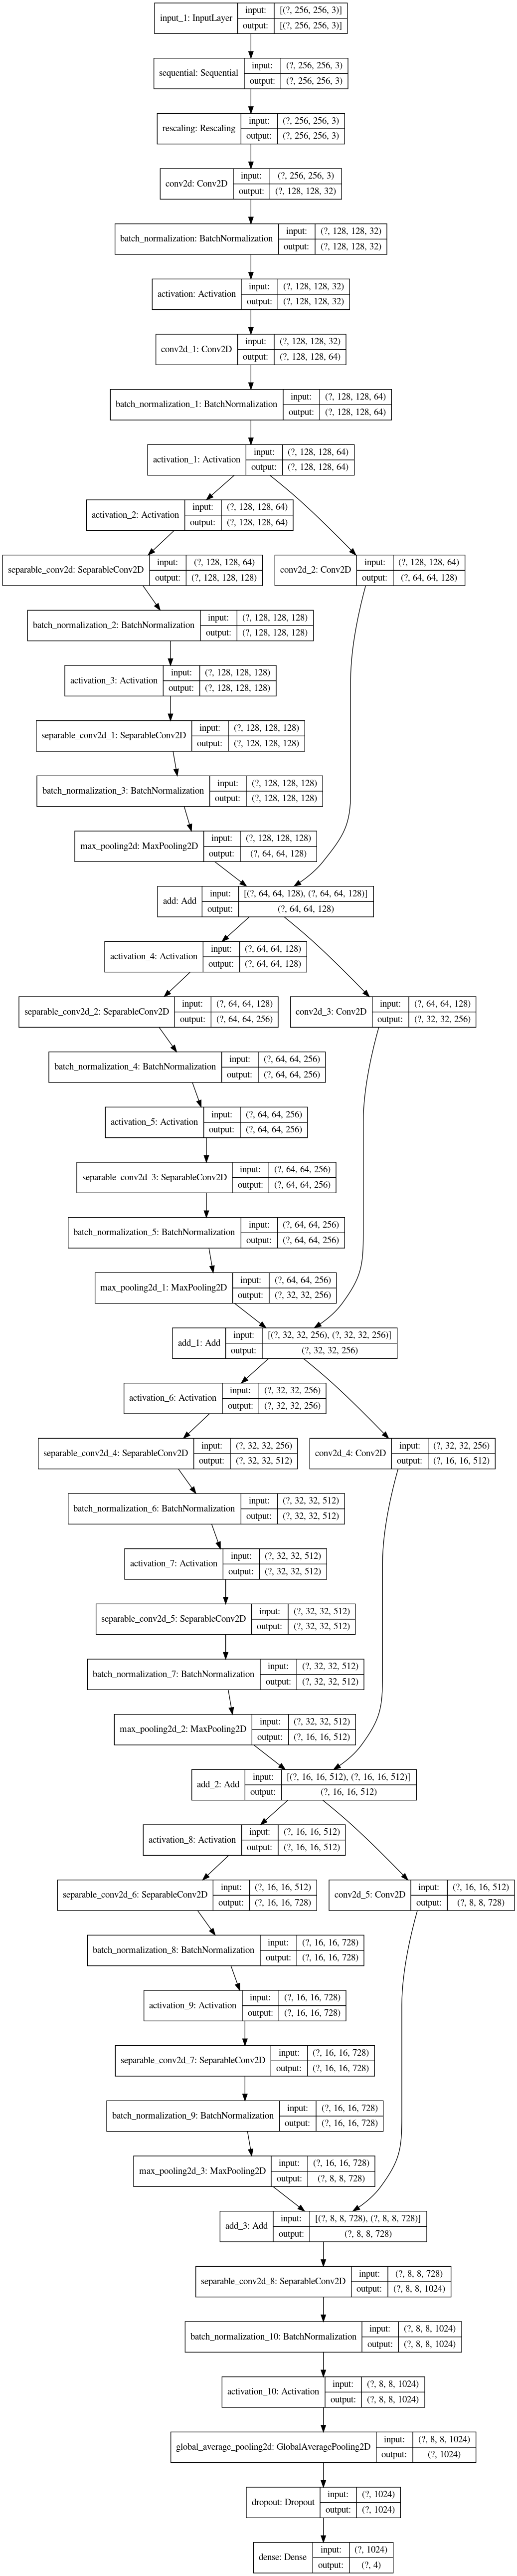

In [21]:
with tf.device('/device:GPU:0'):
    model = make_model(input_shape=image_size + (3,), num_classes=4)
    
keras.utils.plot_model(model, show_shapes=True)

In [22]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
    keras.callbacks.EarlyStopping(patience=5,
                                 monitor='loss')
]

with tf.device('/device:GPU:0'):
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"],
    )

In [23]:

history = model.fit(
    train_ds, 
    epochs=epochs, 
    callbacks=callbacks, 
    validation_data=val_ds,
)

Epoch 1/50
46/46 [==============================] - 26s 560ms/step - loss: 1.2566 - categorical_accuracy: 0.4077 - val_loss: 1.3255 - val_categorical_accuracy: 0.3187
Epoch 2/50
46/46 [==============================] - 16s 351ms/step - loss: 1.2098 - categorical_accuracy: 0.4358 - val_loss: 1.2618 - val_categorical_accuracy: 0.3187
Epoch 3/50
46/46 [==============================] - 16s 350ms/step - loss: 1.2057 - categorical_accuracy: 0.4475 - val_loss: 1.2393 - val_categorical_accuracy: 0.3187
Epoch 4/50
46/46 [==============================] - 16s 351ms/step - loss: 1.1788 - categorical_accuracy: 0.4496 - val_loss: 1.2465 - val_categorical_accuracy: 0.3187
Epoch 5/50
46/46 [==============================] - 16s 351ms/step - loss: 1.1283 - categorical_accuracy: 0.5024 - val_loss: 1.2916 - val_categorical_accuracy: 0.2747
Epoch 6/50
46/46 [==============================] - 16s 351ms/step - loss: 0.7347 - categorical_accuracy: 0.7220 - val_loss: 1.6419 - val_categorical_accuracy: 0.274

In [24]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

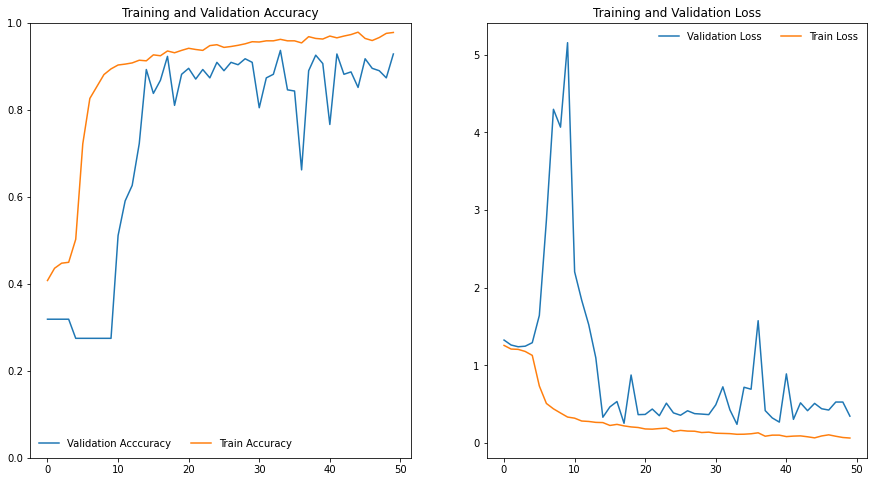

In [25]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.ylim(0, 1)
plt.plot(hist.epoch, 
         hist.val_categorical_accuracy, 
         label="Validation Acccuracy")
plt.plot(hist.epoch, 
         hist.categorical_accuracy, 
         label="Train Accuracy")
plt.legend(loc='lower left',
           ncol=2,
           frameon=False)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(hist.epoch, 
         hist.val_loss, 
         label="Validation Loss")
plt.plot(hist.epoch, 
         hist.loss, 
         label="Train Loss")
plt.legend(loc='upper right',
           ncol=2,
           frameon=False)
plt.title('Training and Validation Loss')
plt.show()

In [26]:
!ls

__notebook__.ipynb  save_at_17.h5  save_at_27.h5  save_at_37.h5  save_at_47.h5
classed		    save_at_18.h5  save_at_28.h5  save_at_38.h5  save_at_48.h5
model.png	    save_at_19.h5  save_at_29.h5  save_at_39.h5  save_at_49.h5
save_at_1.h5	    save_at_2.h5   save_at_3.h5   save_at_4.h5	 save_at_5.h5
save_at_10.h5	    save_at_20.h5  save_at_30.h5  save_at_40.h5  save_at_50.h5
save_at_11.h5	    save_at_21.h5  save_at_31.h5  save_at_41.h5  save_at_6.h5
save_at_12.h5	    save_at_22.h5  save_at_32.h5  save_at_42.h5  save_at_7.h5
save_at_13.h5	    save_at_23.h5  save_at_33.h5  save_at_43.h5  save_at_8.h5
save_at_14.h5	    save_at_24.h5  save_at_34.h5  save_at_44.h5  save_at_9.h5
save_at_15.h5	    save_at_25.h5  save_at_35.h5  save_at_45.h5
save_at_16.h5	    save_at_26.h5  save_at_36.h5  save_at_46.h5
